In [82]:
import numpy as np

In [83]:
class Module:
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        input_grad = module.backward(input, output_grad)
    """
    def __init__ (self):
        self._output = None
        self._input_grad = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        self._output = self._compute_output(input)
        return self._output

    def backward(self, input, output_grad):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self._input_grad = self._compute_input_grad(input, output_grad)
        self._update_parameters_grad(input, output_grad)
        return self._input_grad
    

    def _compute_output(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which will be stored in the `_output` field.

        Example: in case of identity operation:
        
        output = input 
        return output
        """
        raise NotImplementedError
        

    def _compute_input_grad(self, input, output_grad):
        """
        Returns the gradient of the module with respect to its own input. 
        The shape of the returned value is always the same as the shape of `input`.
        
        Example: in case of identity operation:
        input_grad = output_grad
        return input_grad
        """
        
        raise NotImplementedError
    
    def _update_parameters_grad(self, input, output_grad):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zero_grad(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def get_parameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def get_parameters_grad(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

In [84]:
class Sequential(Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add_module(self, module):
        self.modules.append(module)

    def _compute_output(self, input):
        """
        Basic workflow of FORWARD PASS:
        y_0    = module[0].forward(input)
        y_1    = module[1].forward(y_0)
        ...
        output = module[n-1].forward(y_{n-2})
        """
        current_input = input
        for module in self.modules:
            current_input = module.forward(current_input)
        return current_input

    def _compute_input_grad(self, input, output_grad):
        """
        Workflow of BACKWARD PASS:
        g_{n-1} = module[n-1].backward(y_{n-2}, output_grad)
        g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
        ...
        g_1 = module[1].backward(y_0, g_2)
        grad_input = module[0].backward(input, g_1)
        """

        # Initialize gradients with respect to input
        current_grad = output_grad

        # Backward pass through modules
        for module in reversed(self.modules):
            current_input = module._output if module._output is not None else input
            current_grad = module.backward(current_input, current_grad)

        return current_grad

    def zero_grad(self):
        for module in self.modules:
            module.zero_grad()

    def get_parameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.get_parameters() for x in self.modules]

    def get_parameters_grad(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.get_parameters_grad() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self, x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

In [85]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def _compute_output(self, input):
        """
        Args:
            input: batch_size x n_feats1

        Returns:
            output: batch_size x n_feats2
        """
        output = np.dot(input, self.W.T) + self.b
        return output

    def _compute_input_grad(self, input, output_grad):
        grad_input = np.dot(output_grad, self.W)
        return grad_input

    def _update_parameters_grad(self, input, output_grad):
        self.gradW = np.dot(output_grad.T, input)
        self.gradb = np.sum(output_grad, axis=0)

    def zero_grad(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def get_parameters(self):
        return [self.W, self.b]

    def get_parameters_grad(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' % (s[1], s[0])
        return q

In [86]:
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def _compute_output(self, input):
        output = np.maximum(input, 0)
        return output

    def _compute_input_grad(self, input, output_grad):
        grad_input = np.multiply(output_grad, input > 0)
        return grad_input

    def __repr__(self):
        return "ReLU"


In [87]:
class Tanh(Module):
    pass

In [88]:
class Criterion:
    def __init__ (self):
        self._output = None
        self._input_grad = None
        
    def forward(self, input, target):
        """
        Given an input and a target, compute the loss function 
        associated to the criterion and return the result.
        
        For consistency this function should not be overrided,
        all the code goes in `_compute_output`.
        """
        self._output = self._compute_output(input, target)
        return self._output

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `_compute_input_grad`.
        """
        self._input_grad = self._compute_input_grad(input, target)
        return self._input_grad
    
    def _compute_output(self, input, target):
        """
        Function to override.
        """
        raise NotImplementedError

    def _compute_input_grad(self, input, target):
        """
        Returns gradient of input wrt output
        
        Function to override.
        """
        raise NotImplementedError

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"

In [89]:
class NegativeLogLikelihood(Criterion):
    def _compute_output(self, input, target):
        """
        Computes the negative log-likelihood loss assuming a Normal distribution.

        Args:
            input: Predicted mean values from the model
            target: Ground truth values

        Returns:
            output: Negative log-likelihood loss
        """
        mean = input
        variance = np.exp(input[1])  # Assuming the second element of input is log variance

        # Negative log-likelihood for a Normal distribution
        if target is not None:
            # Negative log-likelihood for a Normal distribution
            loss = 0.5 * np.log(2 * np.pi * variance) + 0.5 * ((target - mean)**2) / variance
            return loss.sum()
        else:
            # If target is None, return 0 or handle it based on your specific use case
            return 0.0  # You might want to return a default value or raise an exception

    def _compute_input_grad(self, input, target):
        """
        Computes the gradient of the negative log-likelihood loss with respect to the input.

        Args:
            input: Predicted mean values from the model
            target: Ground truth values

        Returns:
            grad_input: Gradient of the loss with respect to the input
        """
        mean = input
        variance = np.exp(input[1])  # Assuming the second element of input is log variance

        diff = target - mean
        grad_input = np.zeros_like(input)
        grad_input[0] = -diff / variance
        grad_input[1] = -0.5 + 0.5 * (diff**2) / variance - 0.5 * np.exp(-input[1])
        return grad_input

In [90]:
class Optimizer:
    def __init__(self, network):
        self._network = network  # contains trainable paramenters and their gradients
        self._state = {}  # any information needed to save between optimizer iterations

    def step(self):
        """
        Updates network parameters
        """
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, network, lr, momentum=0.0):
        super(SGD, self).__init__(network)
        self._learning_rate = lr
        self._momentum = momentum
        
    def step(self):
        variables = self._network.get_parameters()
        gradients = self._network.get_parameters_grad()
        
        # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
        self._state.setdefault('accumulated_grads', {})
    
        var_index = 0 
        for current_layer_vars, current_layer_grads in zip(variables, gradients):
            for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
                old_grad = self._state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
                np.add(self._momentum * old_grad, current_grad, out=old_grad)
                current_var -= self._learning_rate * old_grad
                var_index += 1

In [91]:
class RealNVPBlock(Module):
    def __init__(self, size, reverse=False):
        super(RealNVPBlock, self).__init__()

        # The two operations
        self.scale = Sequential()
        self.scale.add_module(Linear(size , size // 2))
        self.scale.add_module(ReLU())

        self.translate = Sequential()
        self.translate.add_module(Linear(size , size // 2))
        self.translate.add_module(ReLU())

        self.mask = np.zeros(size)
        mid = int(size / 2)
        if reverse:
            self.mask[mid:] = 1.
        else:
            self.mask[:mid] = 1.

    def generation(self, z):
        inverse_mask = 1 - self.mask
        z_masked = z * inverse_mask

        x = z_masked + self.mask * self.scale.forward(z_masked) + self.translate.forward(z_masked)
        return x

    def inference(self, x):
        inverse_mask = 1 - self.mask
        x_masked = x * inverse_mask

        z = x_masked - self.translate.forward(x_masked)
        z /= self.scale.forward(x_masked) + 1e-8  # Add a small epsilon to avoid division by zero
        log_det_jacobian = np.sum(np.log(np.abs(self.scale.forward(x_masked)) + 1e-8))

        return z, log_det_jacobian

In [92]:
class RealNVP(Module):
    def __init__(self, size, n_layers):
        super().__init__()

        # Assuming prior is a Normal distribution
        self.prior = NegativeLogLikelihood()

        # Sequence of RealNVPBlock-s
        self.layers = Sequential()
        for i in range(n_layers):
            self.layers.add_module(RealNVPBlock(size))

    def generation(self, z):
        x = z
        for layer in self.layers:
            x = layer.generation(x)
        return x

    def inference(self, x):
        log_det_jacobian = 0.
        z = x
        for layer in reversed(self.layers.modules):
            z, layer_log_det_jacobian = layer.inference(z)
            log_det_jacobian += layer_log_det_jacobian

        return z, log_det_jacobian

    def sample(self, n_samples):
        z = np.random.normal(size=(n_samples, 2))  # Assuming 2D input for Moon dataset
        x = self.generation(z)
        return x

    def negative_log_likelihood(self, x):
        z, log_det_jacobian = self.inference(x)
        prior_loss = self.prior.forward(z, None)  # No target for the prior
        return log_det_jacobian + prior_loss

    def train(self):
        super().train()
        for layer in self.layers.modules:
            layer.train()

    def evaluate(self):
        super().evaluate()
        for layer in self.layers.modules:
            layer.evaluate()

Epoch 0, Loss: -11.350330566026088
Epoch 100, Loss: -11.350330566026088
Epoch 200, Loss: -11.350330566026088
Epoch 300, Loss: -11.350330566026088
Epoch 400, Loss: -11.350330566026088
Epoch 500, Loss: -11.350330566026088
Epoch 600, Loss: -11.350330566026088
Epoch 700, Loss: -11.350330566026088
Epoch 800, Loss: -11.350330566026088
Epoch 900, Loss: -11.350330566026088


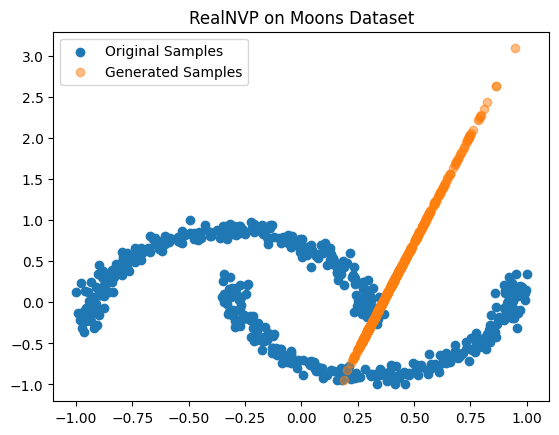

In [97]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate Moons dataset
np.random.seed(42)
X, _ = make_moons(n_samples=500, noise=0.05)

# Normalize data to be in the range [-1, 1]
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0)) * 2 - 1

# Define RealNVP model
realnvp = RealNVP(size=2, n_layers=4)

# Training parameters
learning_rate = 0.001
momentum = 0.8
num_epochs = 1000

# Optimizer
optimizer = SGD(realnvp, lr=learning_rate, momentum=momentum)

# Training loop
for epoch in range(num_epochs):
    # Negative log-likelihood as the loss function
    loss = 0.
    for sample in X:
        loss += realnvp.negative_log_likelihood(sample)
    
    loss /= X.shape[0]

    # Backward pass and optimization
    optimizer.step()

    # Print loss every few epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Sample from the trained RealNVP model
generated_samples = realnvp.sample(n_samples=500)

# Plot the original and generated samples
plt.scatter(X[:, 0], X[:, 1], label='Original Samples')
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], label='Generated Samples', alpha=0.5)
plt.legend()
plt.title('RealNVP on Moons Dataset')
plt.show()

# В этот раз не вышло......